In [1]:
from configs.task_1 import get_config
from model import MyModel
from utils.vis import PCA, tsne

import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import seaborn as sns
from flax.training.checkpoints import restore_checkpoint

%matplotlib inline

sns.set_theme()

palette = sns.color_palette()

# Metric visualization

In [2]:
import numpy as np
import os
import pickle

pth = os.path.join("metrics", "e100_adamw_234.pkl")

with open(pth, "rb") as fd:
  metrics = pickle.load(fd)

train_loss = metrics["train"]["loss"]
val_loss = metrics["val"]["loss"]
train_acc = metrics["train"]["accuracy"]
val_acc = metrics["val"]["accuracy"]

xs = np.arange(100).reshape(-1, 1)
xs = np.repeat(xs, val_acc.shape[1], axis=1).flatten()

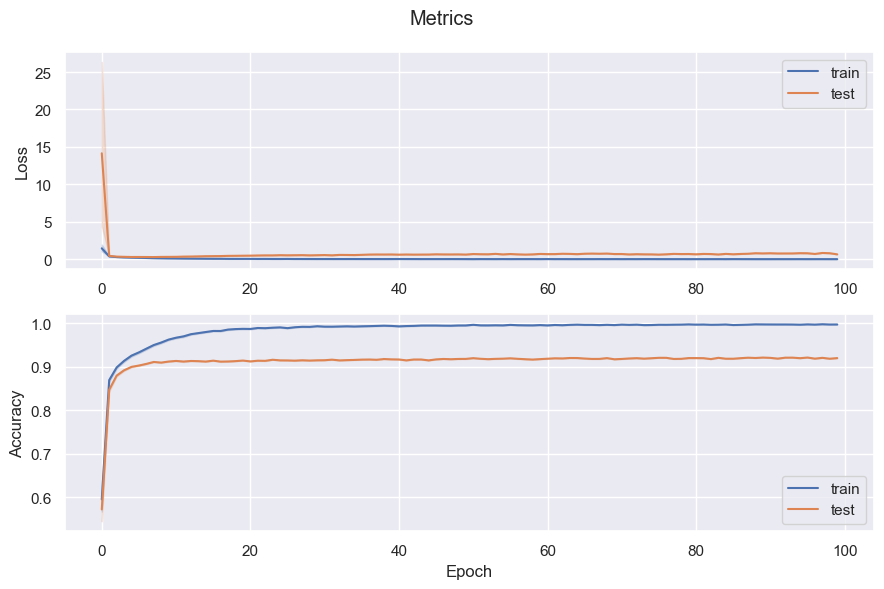

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

sns.lineplot(x=xs, y=train_loss.flatten(), ax=axes[0], label="train")
sns.lineplot(x=xs, y=val_loss.flatten(), ax=axes[0], label="test")
sns.lineplot(x=xs, y=train_acc.flatten(), ax=axes[1], label="train")
sns.lineplot(x=xs, y=val_acc.flatten(), ax=axes[1], label="test")

axes[0].legend()
axes[0].set_ylabel("Loss")
axes[1].legend()
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

fig.suptitle("Metrics")
fig.tight_layout()

In [4]:
fig.savefig("outputs/task1_metrics.pdf")

# Model output visualization

In [5]:
from task1_dataset import get_data

X_train, X_test, y_train, y_test = get_data("task1_dataset")
train_imgs = jnp.einsum("bchw->bhwc", jnp.array(X_train[:1000]))
train_labels = jnp.array(y_train[:1000])
test_imgs = jnp.einsum("bchw->bhwc", jnp.array(X_test))
test_labels = jnp.array(y_test)

In [6]:
config = get_config()
variables = restore_checkpoint("ckpts", None, prefix="task1_")
model = MyModel(config)

In [7]:
from model import ConvPoolBlock, ConvResBlock, partial

class MyModelConv(nn.Module):
  @nn.compact
  def __call__(self, inp):
    inp = ConvPoolBlock(config.conv_pool, 2, 8)(inp, False)
    inp = ConvPoolBlock(config.conv_pool, 2, 64)(inp, False)
    inp = ConvPoolBlock(config.conv_pool, 3, 128)(inp, False)
    inp = ConvResBlock(config.conv_res, 3, 128)(inp, False)
    inp = ConvPoolBlock(config.conv_pool, 4, 256)(inp, False)
    inp = ConvResBlock(config.conv_res, 4, 256)(inp, False)

    return inp

class MyModelDense(nn.Module):
  @nn.compact
  def __call__(self, inp):
    dense = partial(nn.Dense,
                    dtype=config.dtype,
                    kernel_init=config.kernel_init,
                    bias_init=config.bias_init)

    inp = ConvPoolBlock(config.conv_pool, 2, 8)(inp, False)
    inp = ConvPoolBlock(config.conv_pool, 2, 64)(inp, False)
    inp = ConvPoolBlock(config.conv_pool, 3, 128)(inp, False)
    inp = ConvResBlock(config.conv_res, 3, 128)(inp, False)
    inp = ConvPoolBlock(config.conv_pool, 4, 256)(inp, False)
    inp = ConvResBlock(config.conv_res, 4, 256)(inp, False)

    inp = inp.reshape(inp.shape[0], -1)
    inp = nn.relu(dense(4096)(inp))

    return inp

conv = MyModelConv()
dense = MyModelDense()

In [8]:
# vis_imgs = train_imgs
# vis_labels = train_labels
vis_imgs = test_imgs[:1000]
vis_labels = test_labels[:1000]

conv_output = conv.apply(variables, vis_imgs).reshape(1000, -1)
dense_output = dense.apply(variables, vis_imgs).reshape(1000, -1)
final = model.apply(variables, vis_imgs, False).reshape(1000, -1)
imgs_flatten = vis_imgs.reshape(1000, -1)

In [9]:
pcaed = [PCA(conv_output, 2),
         PCA(dense_output, 2),
         PCA(final, 2)]
tsned = [tsne(None, conv_output, 2, 50, 500),
         tsne(None, dense_output, 2, 50, 500),
         tsne(None, final, 2, 50, 500)]

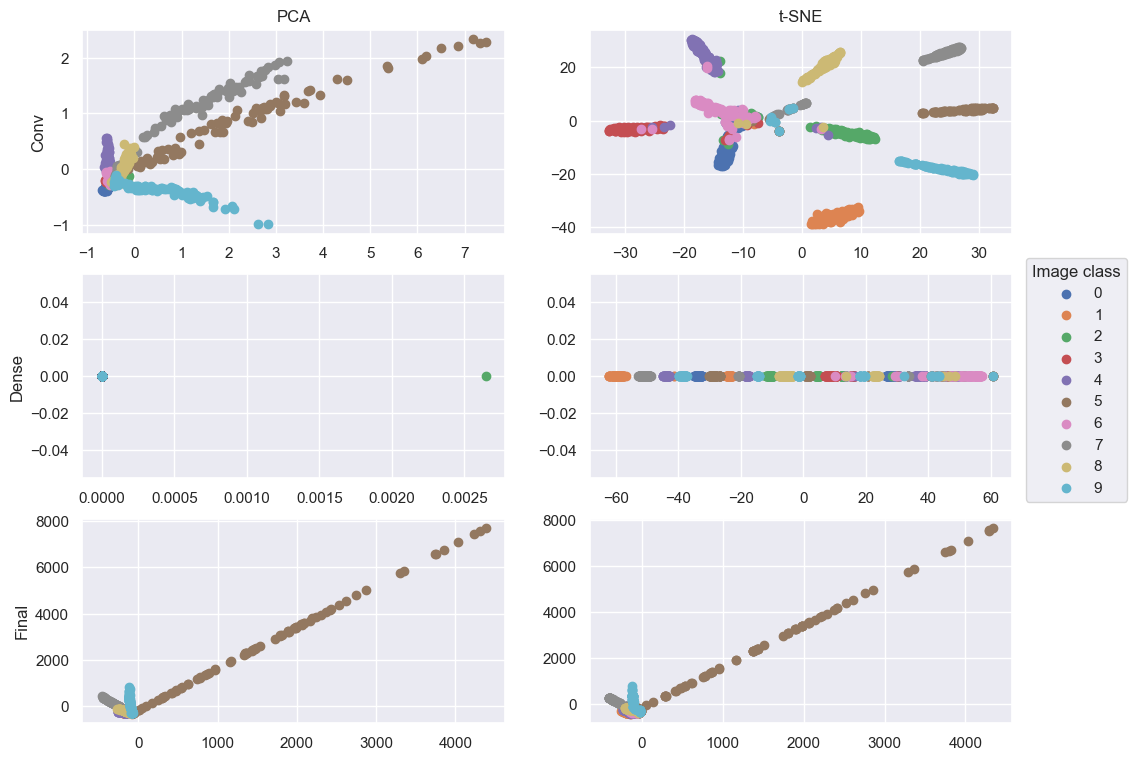

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

for i, d in enumerate([pcaed, tsned]):
  for k, data in enumerate(d):
    for j in range(10):
      axes[k, i].scatter(data[vis_labels == j, 0], data[vis_labels == j, 1], color=palette[j])

axes[0, 0].set_title("PCA")
axes[0, 1].set_title("t-SNE")
axes[0, 0].set_ylabel("Conv")
axes[1, 0].set_ylabel("Dense")
axes[2, 0].set_ylabel("Final")
fig.legend(list(map(str, range(10))), loc="outside right", title="Image class")

In [11]:
fig.savefig("outputs/task1_vis.pdf")